In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

pixel_by_cm=1#6/1464

def find_defects(orig_image,area_thresh=20):  
    list_areas=[]
    list_contour=[]
    lower_range= np.array([0,50,50])
    upper_range = np.array([180,255,255])
    orig_image = cv2.bilateralFilter(orig_image,9,75,75)
#     orig_image = cv2.GaussianBlur(orig_image,(5,5),0)

    #convert to hsv
    hsv = cv2.cvtColor(orig_image, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv, lower_range, upper_range)
    res = cv2.bitwise_and(orig_image,orig_image, mask= mask)
    
    #convert to gray scale as findContours accepts grayScale
    imgray = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)
    
    #find contours 
    image, contours, hierarchy = cv2.findContours(imgray,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
   
    #take contours with area greater than certain threshold
    for contour in contours:
        area=cv2.contourArea(contour)
        if(area>area_thresh):
            list_areas.append(area)
            list_contour.append(contour)
    
    list_areas = np.array(list_areas)
    list_contour = np.array(list_contour)
    #take top 10 highest areas
    inds = list_areas.argsort()[::-1][:5]
    sorted_Contour= list_contour[inds]
    
    #draw contours for defected region
    img = cv2.drawContours(np.copy(orig_image), sorted_Contour[1:], -1, (0,255,0), 3)
    
    return sorted_Contour,img


def get_four_object_pts(Contour):
    list_y=[]
    list_x=[]
    for point in Contour:
        x=point[0][0]
        y=point[0][1]
        list_y.append(y)
        list_x.append(x)
        
    list_y = np.array(list_y)
    list_x = np.array(list_x)
    
    
    inds = list_y.argsort()#[::-1]
    sorted_x_by_y= list_x[inds]
    sorted_y=sorted(list_y)

    inds = list_x.argsort()#[::-1]
    sorted_x=sorted(list_x)
    sorted_y_by_x=list_y[inds]

    top_point=[sorted_x_by_y[0], sorted_y[0]]
    
    bottom_point=[sorted_x_by_y[len(sorted_x_by_y)-1], sorted_y[len(sorted_y)-1]]
    
    left_point=[sorted_x[0], sorted_y_by_x[0]]
    
    right_point=[sorted_x[len(sorted_x)-1], sorted_y_by_x[len(sorted_y_by_x)-1]]
    
    #get height and width
    height=(bottom_point[1]-top_point[1])*pixel_by_cm
    width=(right_point[0]-left_point[0])*pixel_by_cm
    
    print("Height",height)
    print("Width",width)
    return top_point,bottom_point,left_point,right_point,height,width

def check_contour_in_object(sorted_Contour,top_point,bottom_point,left_point,right_point):
    for contour in sorted_Contour[1:]:
        M = cv2.moments(contour)
        #get centroid of the specific contour
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        #check of centroid is in range of the beject boundary
        if(top_point[1]+20<cy<bottom_point[1]-20 and left_point[0]+20<cx<right_point[0]-20):
            return True
    return False

def draw_defect_convex(sorted_Contour,orig_image):    
    defect_contour=[]
    hull=[]
    
    #merge all the defects
    for contour in sorted_Contour[1:]:
        for points in contour:
            defect_contour.append(points)

    # creating convex hull object for each contour
    hull.append(cv2.convexHull(np.array(defect_contour), False))
    img = cv2.drawContours(np.copy(orig_image), hull, -1, (0,255,0), 3)
    return img

def plot_object_boundary_pts(top_point,bottom_point,left_point,right_point):
    #plot top,bottom,left,right points of object boundary
    plt.scatter([top_point[0]], [top_point[1]],linewidths=15)
    plt.scatter([bottom_point[0]],[bottom_point[1]],linewidths=15)
    plt.scatter([left_point[0]],[left_point[1]],linewidths=15)
    plt.scatter([right_point[0]],[right_point[1]],linewidths=15)

def plot_contour_boundary(orig_image,sorted_Contour):
    img = cv2.drawContours(np.copy(orig_image), sorted_Contour, -1, (0,0,255), 5)
    return img


def pipeline_fruits(orig_image):
    #get defects of the fruit
    sorted_Contour,image_defects=find_defects(np.copy(orig_image))
    object_contour=sorted_Contour[0]
    #get four object points
    top_point,bottom_point,left_point,right_point,height,width=get_four_object_pts(object_contour)
    boundary_img=plot_contour_boundary(np.copy(orig_image),object_contour)

    if(len(sorted_Contour)>1):
        
        #check contour in object or not
        ret=check_contour_in_object(sorted_Contour,top_point,bottom_point,left_point,right_point)
        #plot contour boundary
       
        if(ret):
            print("Defects detected")
            convex_img=draw_defect_convex(sorted_Contour,np.copy(orig_image))
            f, [ax1, ax2,ax3] = plt.subplots(1, 3, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(image_defects)
            plot_object_boundary_pts(top_point,bottom_point,left_point,right_point)
            ax2.imshow(boundary_img)
            ax3.imshow(convex_img)
            return None

    print("No Defects detected")
    plt.imshow(boundary_img)
    plot_object_boundary_pts(top_point,bottom_point,left_point,right_point)


Height 452
Width 441
Defects detected


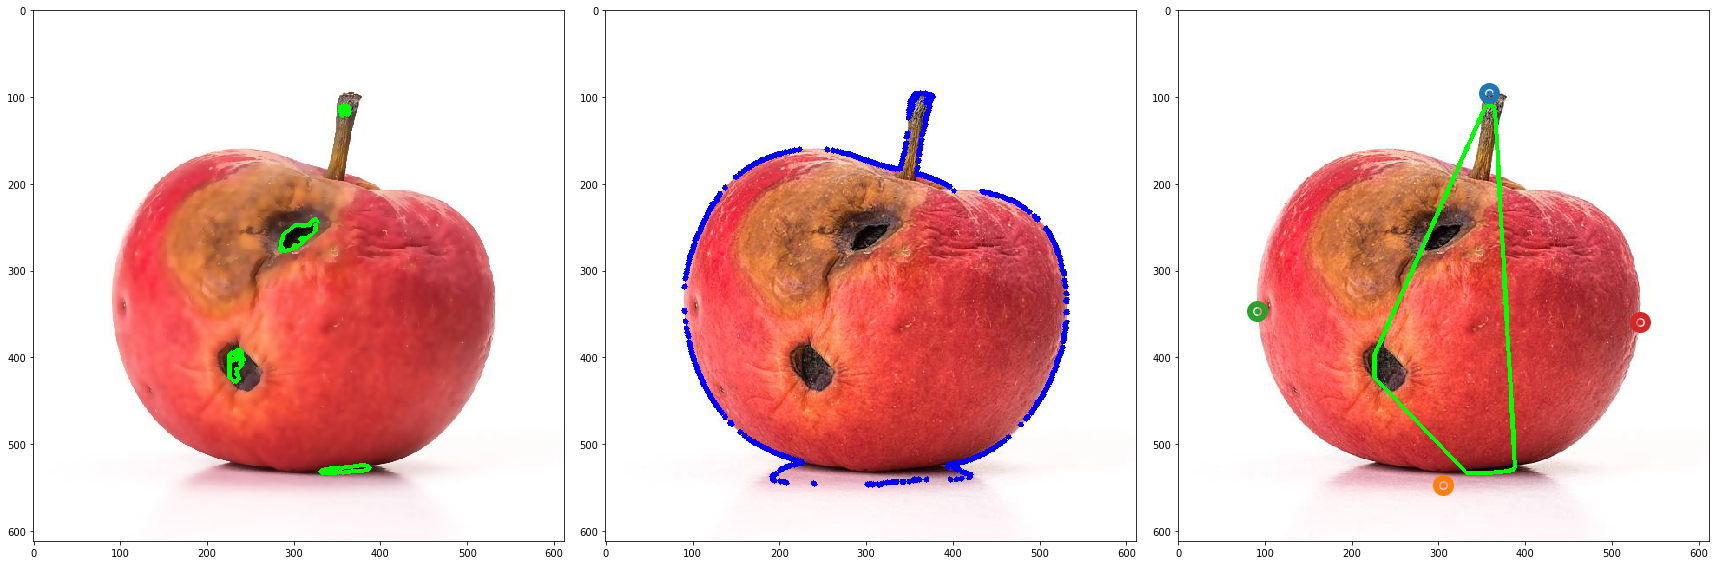

In [16]:
orig_image=plt.imread("rot_1.jpg")

pipeline_fruits(orig_image)

Height 707
Width 669
Defects detected


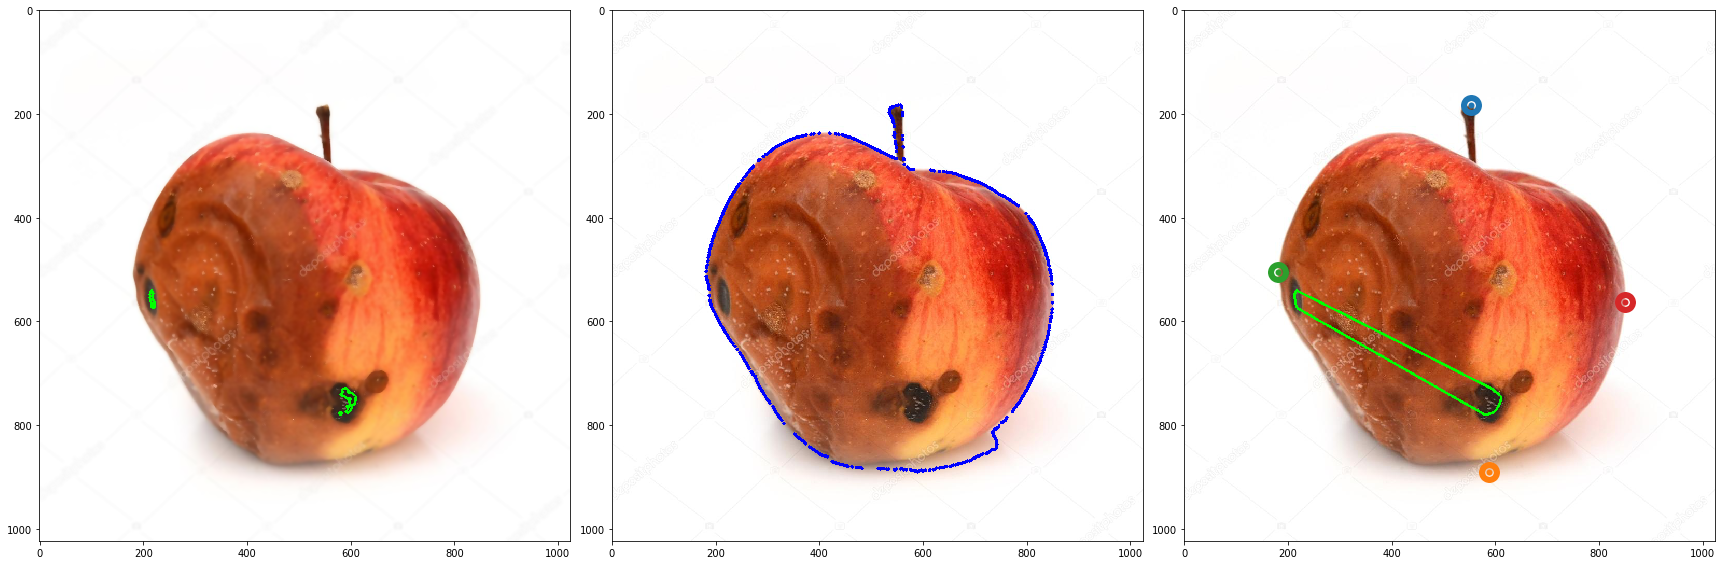

In [17]:
orig_image=plt.imread("rot_2.jpg")
pipeline_fruits(orig_image)

Height 136
Width 237
No Defects detected


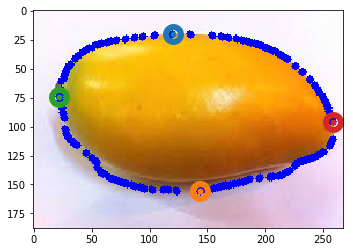

In [18]:
orig_image=plt.imread("mn_1.jpg")
pipeline_fruits(orig_image)

Height 2142
Width 2121
No Defects detected


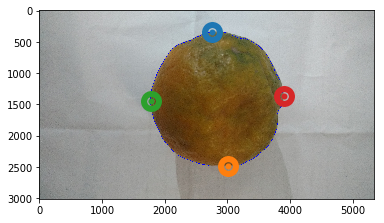

In [19]:
orig_image=plt.imread("or_2.jpg")
pipeline_fruits(orig_image)

Height 123
Width 245
Defects detected


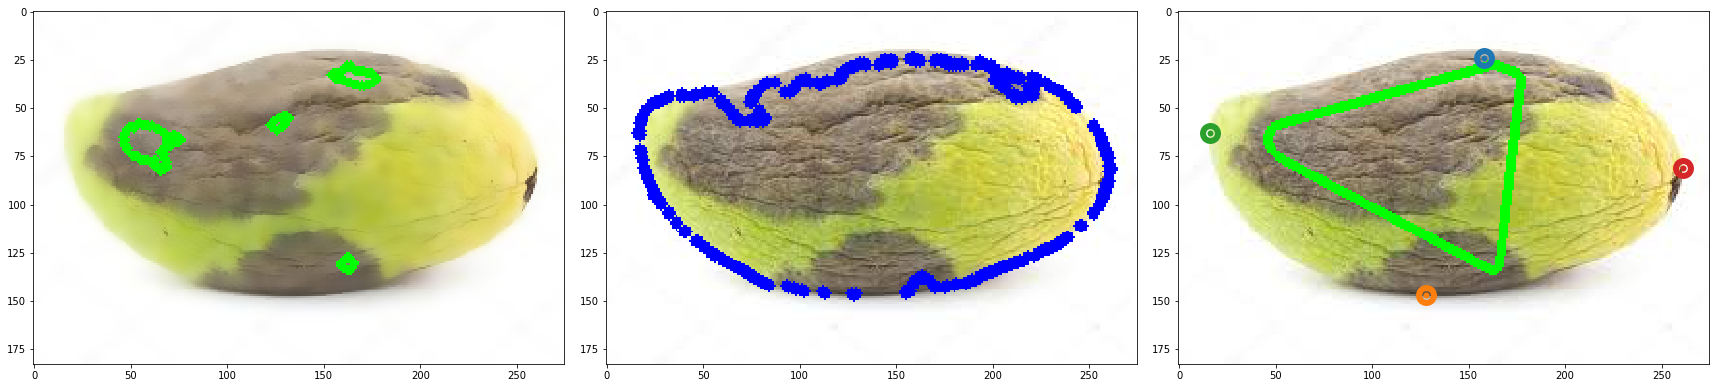

In [20]:
orig_image=plt.imread("mnr_1.jpg")
pipeline_fruits(orig_image)

Height 409
Width 466
No Defects detected


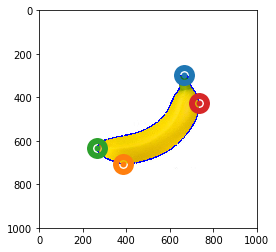

In [21]:
orig_image=plt.imread("bn_1.jpg")
pipeline_fruits(orig_image)

Height 755
Width 738
Defects detected


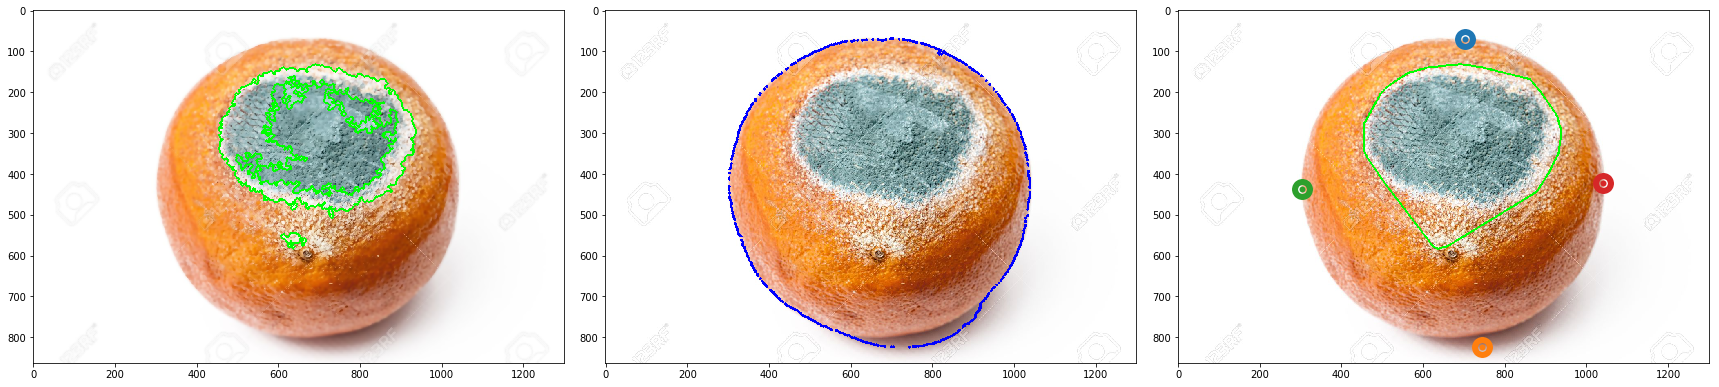

In [22]:
orig_image=plt.imread("orr3.jpg")
pipeline_fruits(orig_image)

Height 183
Width 181
No Defects detected


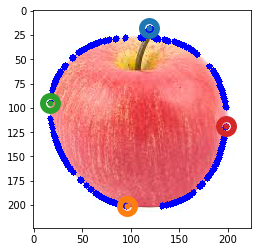

In [23]:
orig_image=plt.imread("a1.jpg")
pipeline_fruits(orig_image)